In [1]:
#!pip install tqdm

import urllib.request
import zipfile
import os
from tqdm import tqdm

# Function to download a file with a progress bar
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

#url = "https://nlp.stanford.edu/data/glove.6B.zip"
#output = "glove.6B.zip"

# Download the GloVe embeddings with a progress bar
#with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
    #urllib.request.urlretrieve(url, filename=output, reporthook=t.update_to)


# Unzip the downloaded file
#with zipfile.ZipFile(output, 'r') as zip_ref:
    #zip_ref.extractall()

# Ensure gensim is installed
#!pip install gensim

# Import KeyedVectors from gensim and load the word vectors
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('glove.6B.50d.txt', binary=False, no_header=True)

In [2]:
#!pip install ipdb
#!pip install torch torch-geometric
#!pip install pandas
#!pip install scikit-learn
#!pip install matplotlib

import pandas as pd
import os
from collections import defaultdict, Counter
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipdb



from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score, r2_score, mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
torch.manual_seed(42)

In [53]:
!unzip drive/MyDrive/slt_challenge/transcripts_outputFiles.zip


'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
def load_graph_info(nodes_degree_txt, nodes_edges_txt):
  nodes_features = defaultdict(dict)
  edges = []
  with open(nodes_degree_txt, 'r') as nodes_degree_file, open(nodes_edges_txt, 'r') as nodes_edges_file:
      reading_nodes, reading_edges = False, False

      for line in nodes_edges_file:
          line = line.strip()
          if (not line) or line.startswith("id*int") or line.startswith("source*int"):
              continue

          if line.startswith("*Nodes"):
              # start reading node info
              reading_nodes = True
              reading_edges = False
          elif line.startswith("*DirectedEdges"):
              # start reading edge info
              reading_nodes = False
              reading_edges = True

          elif reading_nodes:
            # parse node info
              parts = line.split(" ", 2)
              node_id = int(parts[0])
              label = parts[1].strip('"')
              nodes_features[node_id]['label'] = label


          elif reading_edges:
            # parse edge info
              parts = line.split()
              source = int(parts[0])
              target = int(parts[1])
              edges.append((source, target))

      for line in nodes_degree_file:
        line = line.strip()
        if (not line) or (not line.startswith("Node Degree")):
          parts = line.split()
          node_id = int(parts[0])
          degree = parts[1].strip('"')
          nodes_features[node_id]['degree'] = degree

      # print(len(nodes_features), len(edges))
      return nodes_features, edges


def get_word_embedding(word, embedding_dim=50):
    try:
        return torch.tensor(word_vectors[word], dtype=torch.float)
    except KeyError:
        # for words not in the vocabulary, use a zero vector
        # print('WARNING: word not in the vocabulary: ', word)
        return torch.zeros(embedding_dim)


def prep_data_for_gnn(nodes_features, edges):
    # mapping from node ID to index
    node_id_to_index = {node_id: i for i, node_id in enumerate(nodes_features.keys())}

    # create node features: node degrees and word embeddings)
    features = []
    for node_id in nodes_features.keys():
        node_label = nodes_features[node_id]['label']
        node_embeddings = get_word_embedding(node_label)
        # print(node_id,nodes_features[node_id]['degree'])
        # new_value = torch.tensor([15], dtype=torch.int64)
        # tensor = torch.cat((node_embeddings, new_value))

        features.append(node_embeddings)
    #pca = PCA(n_components=pca_components)
    #reduced_features = pca.fit_transform(features)  
    #x = torch.tensor(reduced_features, dtype=torch.float32) 
    x = torch.stack(features) 

    # create edge index tensor
    edge_index = torch.tensor(
        [[node_id_to_index[src], node_id_to_index[dst]] for src, dst in edges],
        dtype=torch.long,
    ).t().contiguous()
    return x, edge_index


def get_datalist(id_list, label_list, transcript_folder):
  """
  returns a list of Data objects
  """
  data_list = []
  id_label_list = [(id, label) for id, label in zip(id_list, label_list)]
  for id, label in id_label_list:
    filepath = os.path.join(transcript_folder, id)
    nodes_features, edges = load_graph_info(f'{filepath}_dir_nodes_degree.txt', f'{filepath}_dir_nodes_edges.txt')
    x, edge_index = prep_data_for_gnn(nodes_features, edges)
    graph_data = Data(x=x, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
    data_list.append(graph_data)
  return data_list


def get_dataloader(data_list, batch_size=None):
  if not batch_size:
    batch_size = len(data_list)
    print('Setting batch size to ', batch_size)
  return DataLoader(data_list, batch_size=batch_size, shuffle=False)

def calculate_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight = 'balanced',
        classes = np.unique(labels),
        y = labels)
   
    return torch.tensor(class_weights, dtype=torch.float)
   


class GNNClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


def train_gnn(train_datalist, train_batch_size=None, hidden_dim=64, lr=0.01, epoches=250, class_weights=None, num_classes = 2):
  torch.manual_seed(42)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  train_dataloader = get_dataloader(train_datalist, batch_size=train_batch_size)

  num_node_features = next(iter(train_dataloader)).x.size(1)

  model = GNNClassifier(input_dim=num_node_features, hidden_dim=hidden_dim, output_dim=num_classes).to(device)
  optimizer = Adam(model.parameters(), lr=lr)

  if class_weights is not None:
      class_weights = class_weights.to(device) 
  loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
  for epoch in range(epoches):
      model.train()
      total_loss = 0

      for batch in train_dataloader:
          batch = batch.to(device)
          optimizer.zero_grad()
          out = model(batch)
          loss = loss_fn(out, batch.y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')

  return model


def eval_gnn(model, eval_datalist, stage_labels=None, print_results=True, batch_size=None):
    model.eval()
    logits_list, pred_list, y_list = [], [], []
    eval_dataloader = get_dataloader(eval_datalist, batch_size=batch_size)
    for batch in eval_dataloader:
        logits = model(batch)
        pred = logits.argmax(dim=1)
        logits_list.append(logits)
        pred_list.append(pred)
        y_list.append(batch.y)
    # concatenate data from all batches
    logits_all = torch.cat(logits_list, dim=0)
    pred_all = torch.cat(pred_list, dim=0)
    y_all = torch.cat(y_list, dim=0)
    # get metrics
    results, disp = calc_metrics(y_all, pred_all, display_labels=stage_labels)
    return logits_all, pred_all, results, disp

def calc_metrics(actual_labels, pred_vals, display_labels=None, print_results=True):
    results = {
        'accuracy': accuracy_score(actual_labels, pred_vals),
        'f1': f1_score(actual_labels, pred_vals, average='macro'),
        'precision': precision_score(actual_labels, pred_vals, average='macro'),
        'recall': recall_score(actual_labels, pred_vals, average='macro')
    }

    cm = confusion_matrix(actual_labels, pred_vals)

    # Get only the unique classes present in the actual predictions
    unique_classes = np.unique(np.concatenate([actual_labels, pred_vals]))  
    if display_labels is None:
        display_labels = [str(label) for label in unique_classes]  # Ensure matching labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    if print_results:
        for metric, value in results.items():
            print(f'{metric}: {value:.3f}')
        disp.plot()
        plt.show()

    return results, disp


class NNMetaModel(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
      super().__init__()
      self.fc1 = Linear(input_dim, hidden_dim)
      self.fc2 = Linear(hidden_dim, output_dim)

  def forward(self, x):
      x = self.fc1(x)
      x = x.relu()
      x = self.fc2(x)
      return x

def train_nn_metamodel(features, labels, epochs=50, hidden_dim=32, lr=0.01, n_tasks=3):
    num_classes = len(torch.unique(labels))
    input_dim = features.shape[1]
    model = NNMetaModel(input_dim, hidden_dim=hidden_dim, output_dim=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(features)
        loss = cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return model


Fold 0:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 38, 2: 10}),
        train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
        dev set for meta model: 32 samples; label count: Counter({0: 17, 1: 11, 2: 4})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.69260
Epoch 50, Loss: 0.10494
Epoch 100, Loss: 0.00087
Epoch 150, Loss: 0.00040
Epoch 200, Loss: 0.00024
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.844
f1: 0.458
precision: 0.435
recall: 0.482


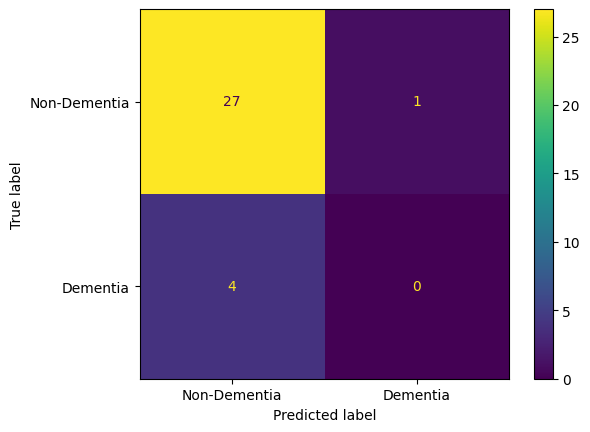

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.69673
Epoch 50, Loss: 0.41367
Epoch 100, Loss: 0.01263
Epoch 150, Loss: 0.00162
Epoch 200, Loss: 0.00074
Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.407
f1: 0.407
precision: 0.417
recall: 0.415


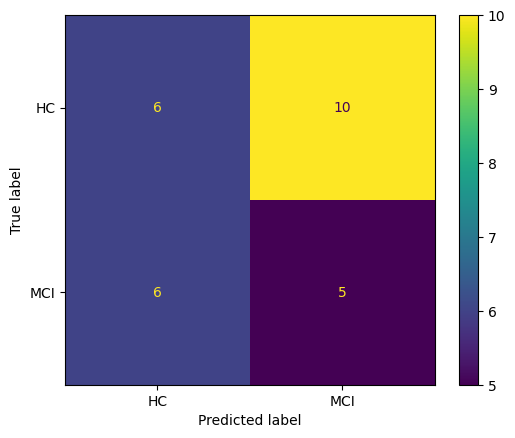

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.35      0.41        17
         MCI       0.33      0.45      0.38        11
    Dementia       0.00      0.00      0.00         4

   micro avg       0.39      0.34      0.37        32
   macro avg       0.28      0.27      0.27        32
weighted avg       0.38      0.34      0.35        32

----------- Task: SFT -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.70459
Epoch 50, Loss: 0.00849
Epoch 100, Loss: 0.00023
Epoch 150, Loss: 0.00014
Epoch 200, Loss: 0.00010
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.812
f1: 0.448
precision: 0.433
recall: 0.464


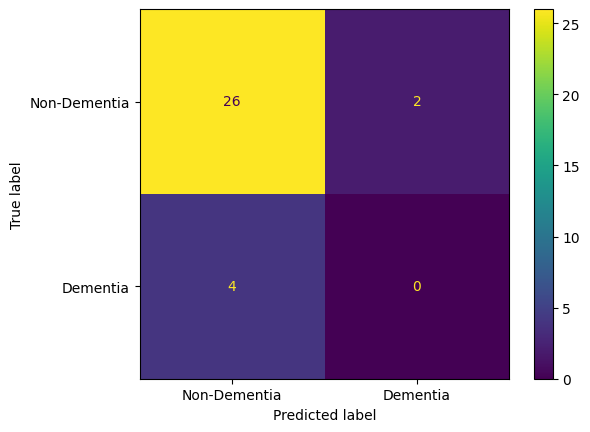

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.69732
Epoch 50, Loss: 0.22729
Epoch 100, Loss: 0.00216
Epoch 150, Loss: 0.00080
Epoch 200, Loss: 0.00048
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.654
f1: 0.627
precision: 0.625
recall: 0.631


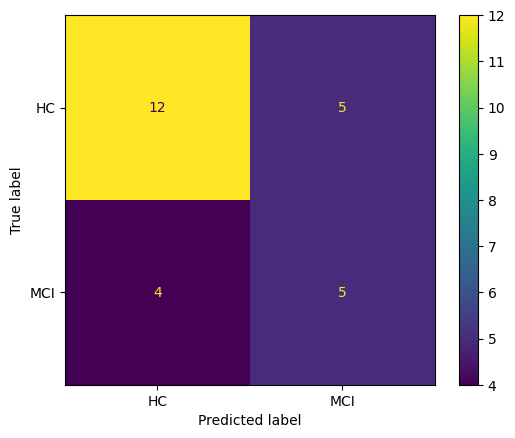

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.75      0.71      0.73        17
         MCI       0.50      0.45      0.48        11
    Dementia       0.00      0.00      0.00         4

   micro avg       0.61      0.53      0.57        32
   macro avg       0.42      0.39      0.40        32
weighted avg       0.57      0.53      0.55        32

----------- Task: PFT -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.69808
Epoch 50, Loss: 0.00052
Epoch 100, Loss: 0.00008
Epoch 150, Loss: 0.00006
Epoch 200, Loss: 0.00004
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.844
f1: 0.599
precision: 0.615
recall: 0.589


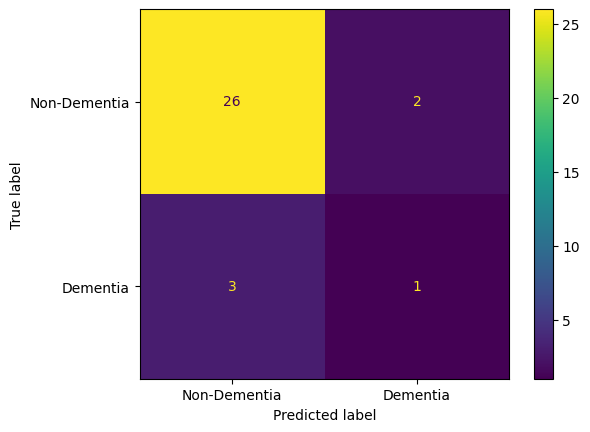

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.68678
Epoch 50, Loss: 0.00177
Epoch 100, Loss: 0.00018
Epoch 150, Loss: 0.00012
Epoch 200, Loss: 0.00008
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.577
f1: 0.519
precision: 0.521
recall: 0.520


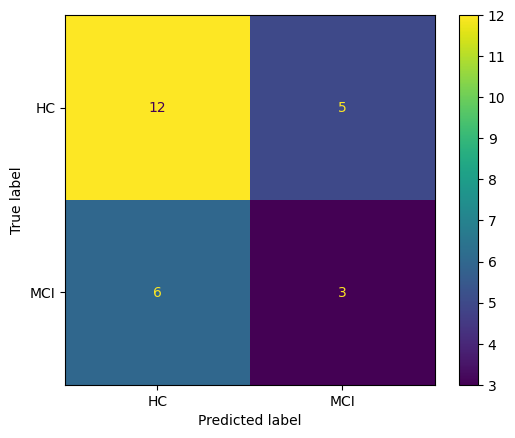

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.71      0.69        17
         MCI       0.38      0.27      0.32        11
    Dementia       0.33      0.25      0.29         4

   micro avg       0.55      0.50      0.52        32
   macro avg       0.46      0.41      0.43        32
weighted avg       0.52      0.50      0.51        32

Fold 1:

        train set for base model: 100 samples; label count: Counter({0: 51, 1: 39, 2: 10}),
        train set for meta model: 25 samples; label count: Counter({0: 13, 1: 10, 2: 2}),
        dev set for meta model: 32 samples; label count: Counter({0: 18, 1: 10, 2: 4})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.69475
Epoch 50, Loss: 0.18519
Epoch 100, Loss: 0.00159
Epoch 150, Loss: 0.00069
Epoch 200, Loss: 0.00042
Validating on meta model dev set...
Setting batch

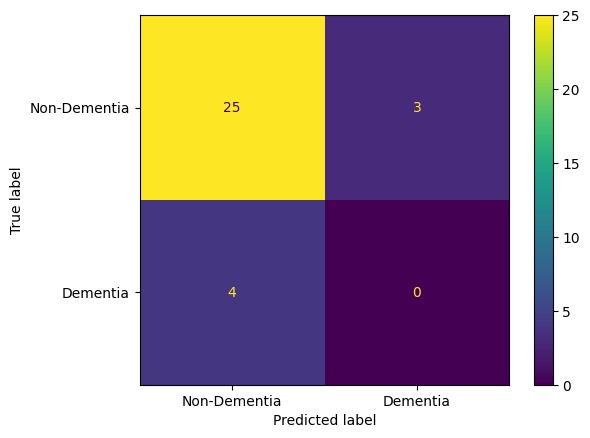

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.69596
Epoch 50, Loss: 0.43971
Epoch 100, Loss: 0.01414
Epoch 150, Loss: 0.00180
Epoch 200, Loss: 0.00088
Validating Stage 2 model on meta model dev set...
Setting batch size to  25
accuracy: 0.520
f1: 0.449
precision: 0.449
recall: 0.449


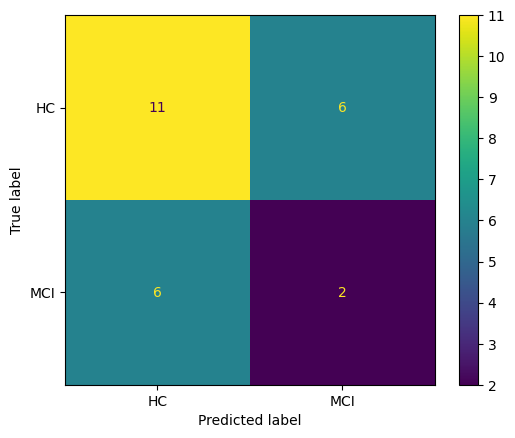

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.65      0.61      0.63        18
         MCI       0.25      0.20      0.22        10
    Dementia       0.00      0.00      0.00         4

   micro avg       0.46      0.41      0.43        32
   macro avg       0.30      0.27      0.28        32
weighted avg       0.44      0.41      0.42        32

----------- Task: SFT -----------
Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.71146
Epoch 50, Loss: 0.00291
Epoch 100, Loss: 0.00020
Epoch 150, Loss: 0.00013
Epoch 200, Loss: 0.00009
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.875
f1: 0.467
precision: 0.438
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


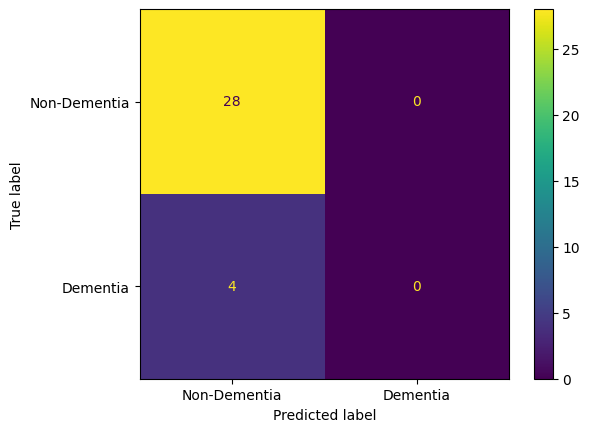

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.69519
Epoch 50, Loss: 0.20453
Epoch 100, Loss: 0.00140
Epoch 150, Loss: 0.00058
Epoch 200, Loss: 0.00036
Validating Stage 2 model on meta model dev set...
Setting batch size to  28
accuracy: 0.500
f1: 0.456
precision: 0.456
recall: 0.456


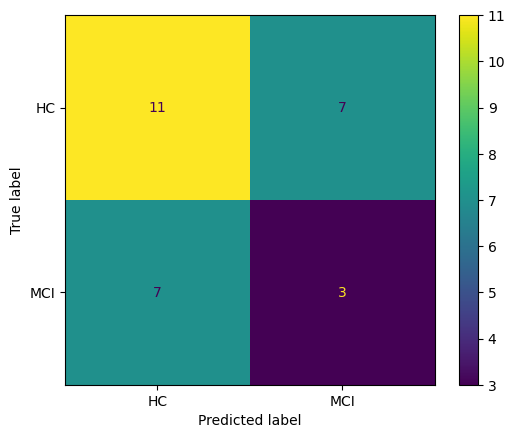

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.61      0.61      0.61        18
         MCI       0.30      0.30      0.30        10
    Dementia       0.00      0.00      0.00         4

   micro avg       0.50      0.44      0.47        32
   macro avg       0.30      0.30      0.30        32
weighted avg       0.44      0.44      0.44        32

----------- Task: PFT -----------


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Training base model train set + meta model train set...
Setting batch size to  125
Epoch 0, Loss: 0.69732
Epoch 50, Loss: 0.00007
Epoch 100, Loss: 0.00002
Epoch 150, Loss: 0.00002
Epoch 200, Loss: 0.00001
Validating on meta model dev set...
Setting batch size to  32
accuracy: 0.750
f1: 0.526
precision: 0.526
recall: 0.536


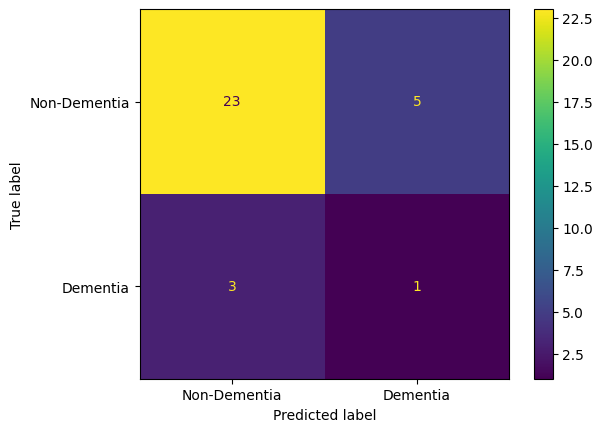

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  113
Epoch 0, Loss: 0.68601
Epoch 50, Loss: 0.00098
Epoch 100, Loss: 0.00014
Epoch 150, Loss: 0.00010
Epoch 200, Loss: 0.00007
Validating Stage 2 model on meta model dev set...
Setting batch size to  23
accuracy: 0.652
f1: 0.589
precision: 0.588
recall: 0.603


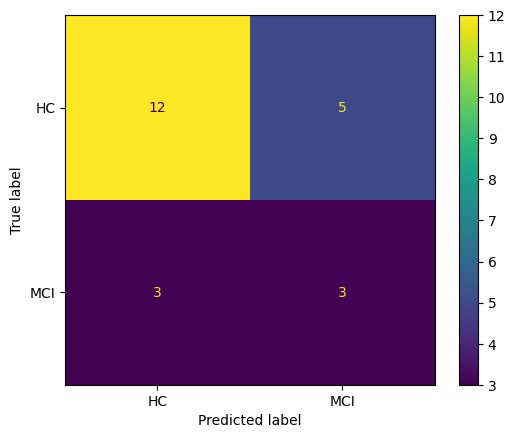

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.80      0.67      0.73        18
         MCI       0.38      0.30      0.33        10
    Dementia       0.17      0.25      0.20         4

   micro avg       0.55      0.50      0.52        32
   macro avg       0.45      0.41      0.42        32
weighted avg       0.59      0.50      0.54        32

Fold 2:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
        train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
        dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69562
Epoch 50, Loss: 0.22515
Epoch 100, Loss: 0.00159
Epoch 150, Loss: 0.00061
Epoch 200, Loss: 0.00036
Validating on meta model dev set...
Setting batch 

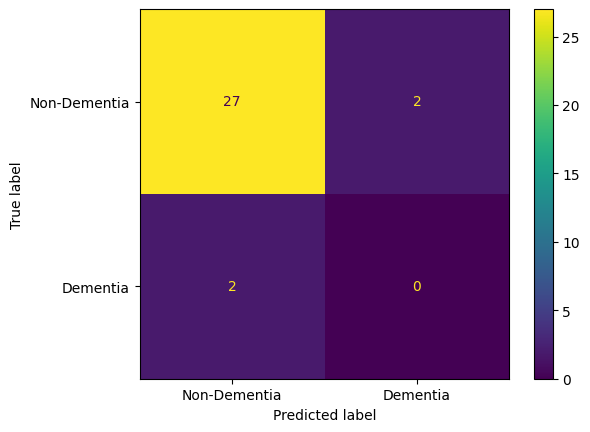

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.69627
Epoch 50, Loss: 0.45265
Epoch 100, Loss: 0.00756
Epoch 150, Loss: 0.00132
Epoch 200, Loss: 0.00069
Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.519
f1: 0.516
precision: 0.516
recall: 0.517


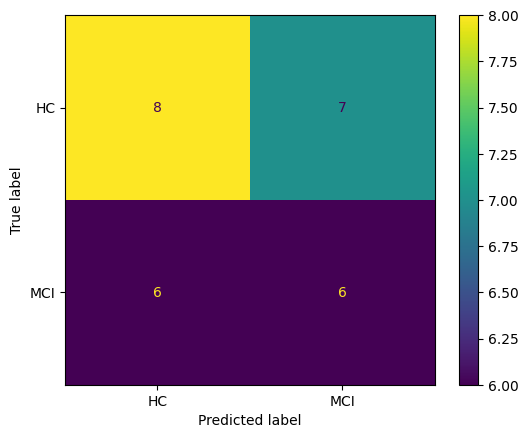

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.57      0.50      0.53        16
         MCI       0.46      0.46      0.46        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.48      0.45      0.47        31
   macro avg       0.34      0.32      0.33        31
weighted avg       0.49      0.45      0.47        31

----------- Task: SFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.70615
Epoch 50, Loss: 0.01307
Epoch 100, Loss: 0.00036
Epoch 150, Loss: 0.00021
Epoch 200, Loss: 0.00014
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.871
f1: 0.631
precision: 0.606
recall: 0.698


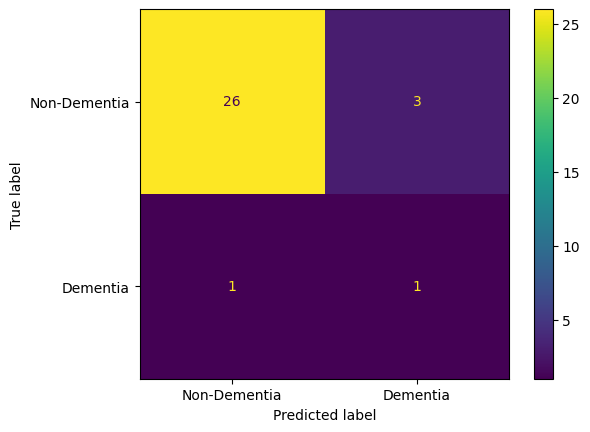

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.69475
Epoch 50, Loss: 0.14950
Epoch 100, Loss: 0.00100
Epoch 150, Loss: 0.00044
Epoch 200, Loss: 0.00028
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.577
f1: 0.561
precision: 0.562
recall: 0.561


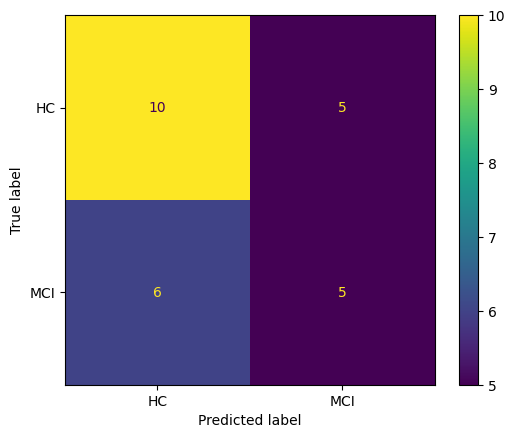

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.62      0.62      0.62        16
         MCI       0.50      0.38      0.43        13
    Dementia       0.25      0.50      0.33         2

   micro avg       0.53      0.52      0.52        31
   macro avg       0.46      0.50      0.46        31
weighted avg       0.55      0.52      0.53        31

----------- Task: PFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69577
Epoch 50, Loss: 0.00015
Epoch 100, Loss: 0.00004
Epoch 150, Loss: 0.00003
Epoch 200, Loss: 0.00002
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.839
f1: 0.456
precision: 0.464
recall: 0.448


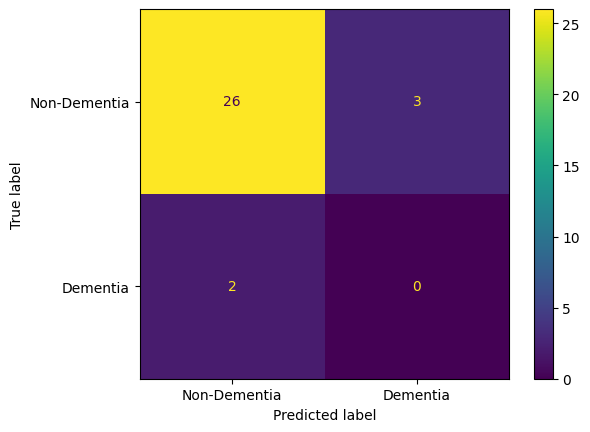

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.68655
Epoch 50, Loss: 0.00138
Epoch 100, Loss: 0.00016
Epoch 150, Loss: 0.00011
Epoch 200, Loss: 0.00008
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.692
f1: 0.675
precision: 0.708
recall: 0.679


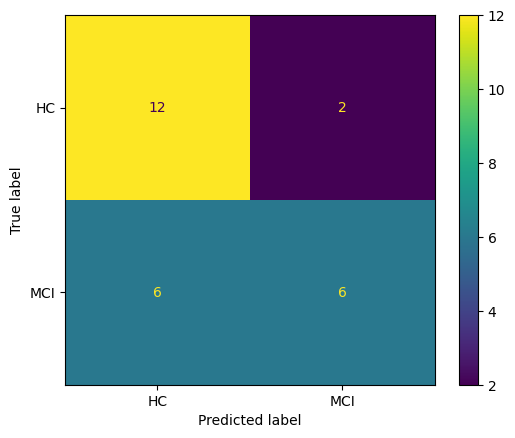

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.67      0.75      0.71        16
         MCI       0.75      0.46      0.57        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.62      0.58      0.60        31
   macro avg       0.47      0.40      0.43        31
weighted avg       0.66      0.58      0.60        31

Fold 3:

        train set for base model: 100 samples; label count: Counter({0: 52, 1: 37, 2: 11}),
        train set for meta model: 26 samples; label count: Counter({0: 14, 1: 9, 2: 3}),
        dev set for meta model: 31 samples; label count: Counter({0: 16, 1: 13, 2: 2})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69549
Epoch 50, Loss: 0.19241
Epoch 100, Loss: 0.00114
Epoch 150, Loss: 0.00045
Epoch 200, Loss: 0.00028
Validating on meta model dev set...
Setting batch 

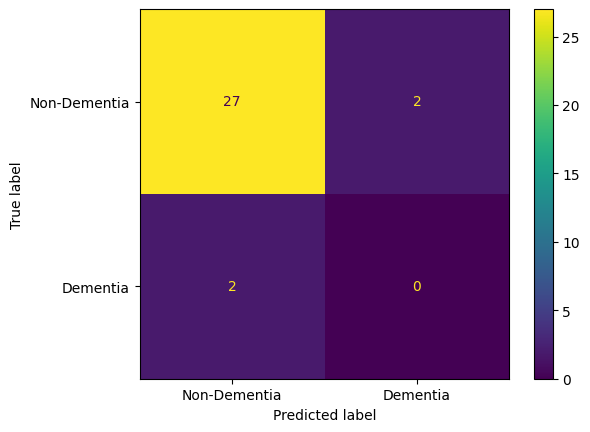

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.69622
Epoch 50, Loss: 0.45666
Epoch 100, Loss: 0.01755
Epoch 150, Loss: 0.00227
Epoch 200, Loss: 0.00109
Validating Stage 2 model on meta model dev set...
Setting batch size to  27
accuracy: 0.667
f1: 0.635
precision: 0.655
recall: 0.634


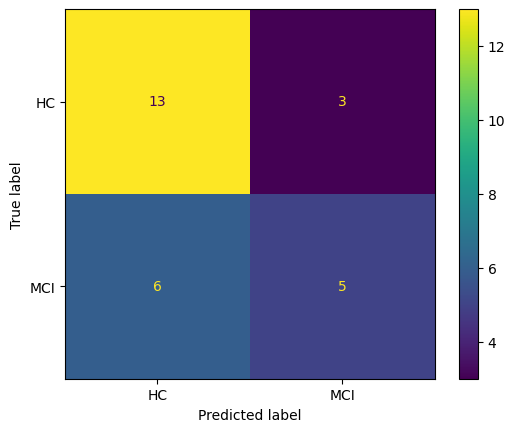

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.68      0.81      0.74        16
         MCI       0.62      0.38      0.48        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.62      0.58      0.60        31
   macro avg       0.44      0.40      0.41        31
weighted avg       0.62      0.58      0.58        31

----------- Task: SFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.70323
Epoch 50, Loss: 0.00680
Epoch 100, Loss: 0.00029
Epoch 150, Loss: 0.00019
Epoch 200, Loss: 0.00014
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.935
f1: 0.483
precision: 0.468
recall: 0.500


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


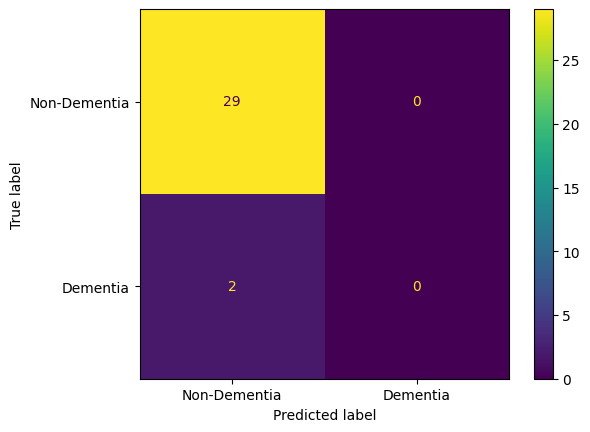

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.69773
Epoch 50, Loss: 0.22282
Epoch 100, Loss: 0.00152
Epoch 150, Loss: 0.00062
Epoch 200, Loss: 0.00039
Validating Stage 2 model on meta model dev set...
Setting batch size to  29
accuracy: 0.552
f1: 0.543
precision: 0.544
recall: 0.543


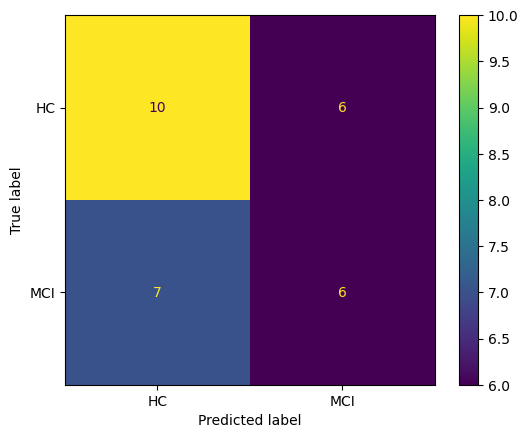

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.59      0.62      0.61        16
         MCI       0.50      0.46      0.48        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.55      0.52      0.53        31
   macro avg       0.36      0.36      0.36        31
weighted avg       0.51      0.52      0.51        31

----------- Task: PFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69840


c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Student\Documents\phd_work\SLT_challenge\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 50, Loss: 0.00025
Epoch 100, Loss: 0.00006
Epoch 150, Loss: 0.00004
Epoch 200, Loss: 0.00003
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.839
f1: 0.456
precision: 0.464
recall: 0.448


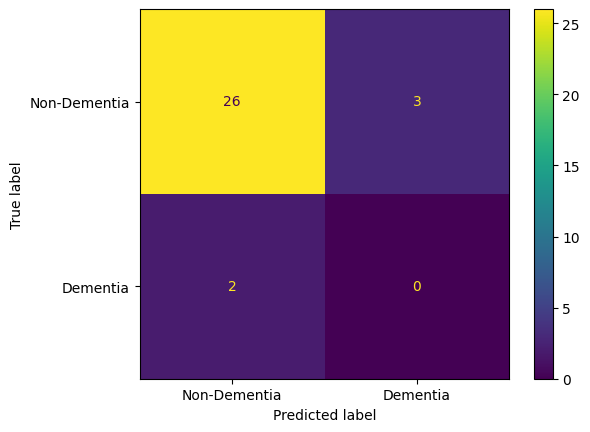

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  112
Epoch 0, Loss: 0.68769
Epoch 50, Loss: 0.00238
Epoch 100, Loss: 0.00021
Epoch 150, Loss: 0.00013
Epoch 200, Loss: 0.00009
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.500
f1: 0.493
precision: 0.500
recall: 0.500


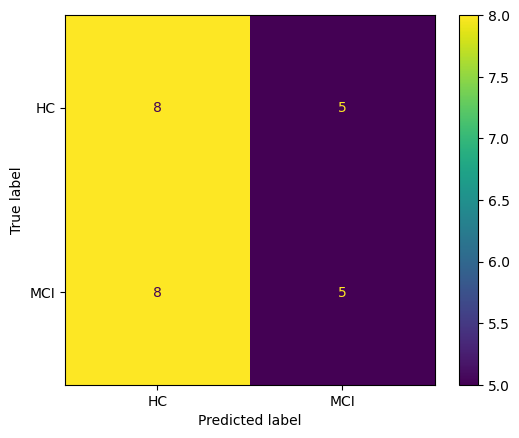

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.50      0.50        16
         MCI       0.50      0.38      0.43        13
    Dementia       0.00      0.00      0.00         2

   micro avg       0.45      0.42      0.43        31
   macro avg       0.33      0.29      0.31        31
weighted avg       0.47      0.42      0.44        31

Fold 4:

        train set for base model: 100 samples; label count: Counter({0: 53, 1: 37, 2: 10}),
        train set for meta model: 26 samples; label count: Counter({0: 14, 1: 10, 2: 2}),
        dev set for meta model: 31 samples; label count: Counter({0: 15, 1: 12, 2: 4})
----------- Task: CTD -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69413
Epoch 50, Loss: 0.22496
Epoch 100, Loss: 0.00188
Epoch 150, Loss: 0.00060
Epoch 200, Loss: 0.00032
Validating on meta model dev set...
Setting batch

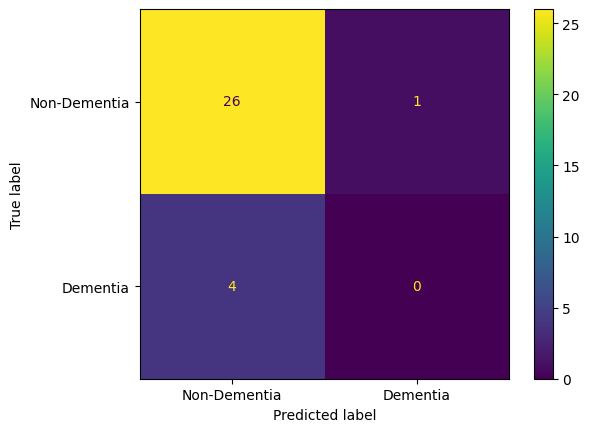

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  114
Epoch 0, Loss: 0.69577
Epoch 50, Loss: 0.39934
Epoch 100, Loss: 0.01396
Epoch 150, Loss: 0.00193
Epoch 200, Loss: 0.00094
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.654
f1: 0.627
precision: 0.673
recall: 0.637


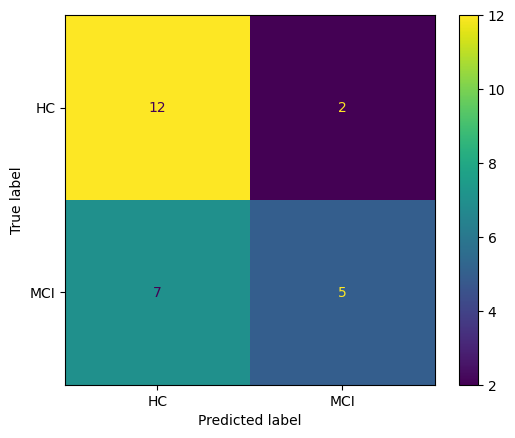

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.63      0.80      0.71        15
         MCI       0.71      0.42      0.53        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.63      0.55      0.59        31
   macro avg       0.45      0.41      0.41        31
weighted avg       0.58      0.55      0.55        31

----------- Task: SFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69387
Epoch 50, Loss: 0.00441
Epoch 100, Loss: 0.00016
Epoch 150, Loss: 0.00011
Epoch 200, Loss: 0.00008
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.839
f1: 0.456
precision: 0.433
recall: 0.481


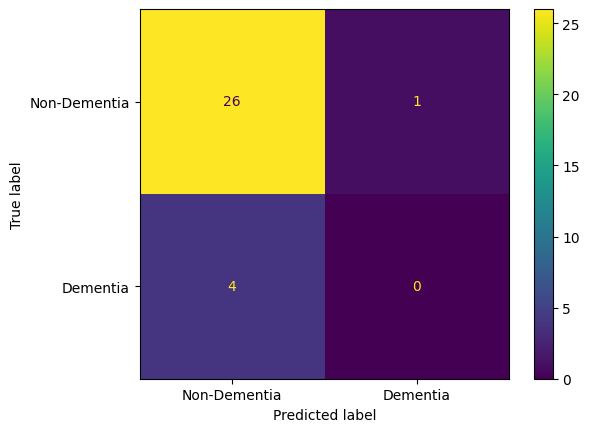

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  114
Epoch 0, Loss: 0.69582
Epoch 50, Loss: 0.19498
Epoch 100, Loss: 0.00204
Epoch 150, Loss: 0.00068
Epoch 200, Loss: 0.00039
Validating Stage 2 model on meta model dev set...
Setting batch size to  26
accuracy: 0.462
f1: 0.448
precision: 0.448
recall: 0.448


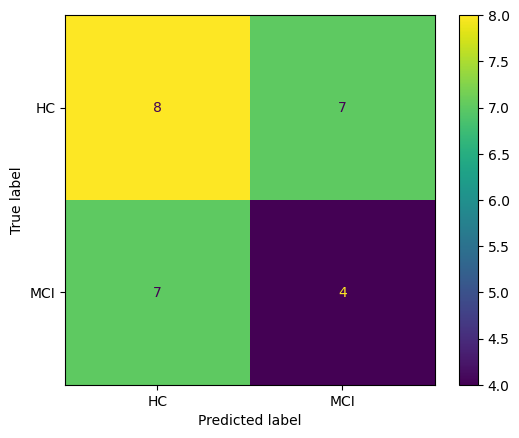

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.53      0.53      0.53        15
         MCI       0.36      0.33      0.35        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.44      0.39      0.41        31
   macro avg       0.30      0.29      0.29        31
weighted avg       0.40      0.39      0.39        31

----------- Task: PFT -----------
Training base model train set + meta model train set...
Setting batch size to  126
Epoch 0, Loss: 0.69341
Epoch 50, Loss: 0.00019
Epoch 100, Loss: 0.00004
Epoch 150, Loss: 0.00003
Epoch 200, Loss: 0.00003
Validating on meta model dev set...
Setting batch size to  31
accuracy: 0.806
f1: 0.446
precision: 0.431
recall: 0.463


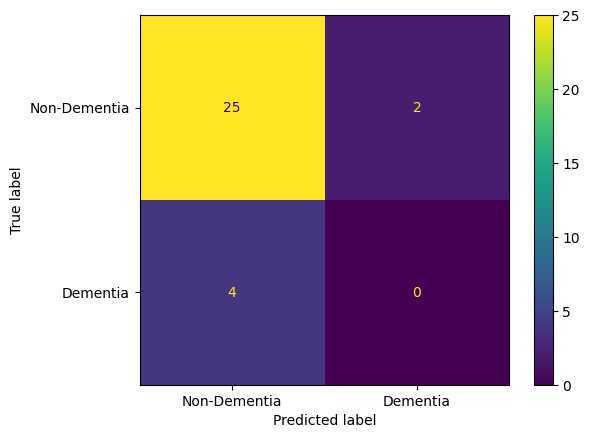

Training base model for Healthy vs. MCI (Stage 2)...
Setting batch size to  114
Epoch 0, Loss: 0.68745
Epoch 50, Loss: 0.00140
Epoch 100, Loss: 0.00017
Epoch 150, Loss: 0.00011
Epoch 200, Loss: 0.00008
Validating Stage 2 model on meta model dev set...
Setting batch size to  25
accuracy: 0.440
f1: 0.392
precision: 0.393
recall: 0.412


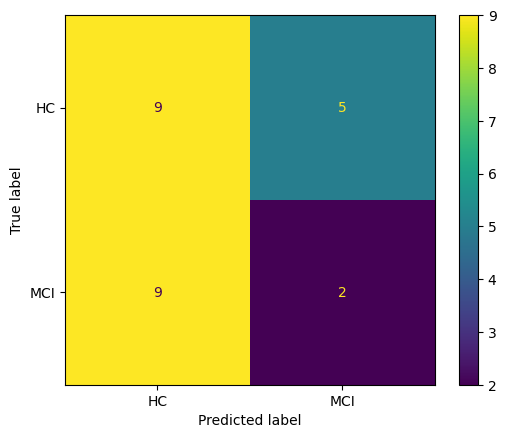

Overall Performance on Ensemble Development Dataset:
              precision    recall  f1-score   support

          HC       0.50      0.60      0.55        15
         MCI       0.29      0.17      0.21        12
    Dementia       0.00      0.00      0.00         4

   micro avg       0.41      0.35      0.38        31
   macro avg       0.26      0.26      0.25        31
weighted avg       0.35      0.35      0.35        31

Mean F1 Score for CTD task (Stage 1 - Dementia vs. Non-Dementia): 0.457
Mean F1 Score for SFT task (Stage 1 - Dementia vs. Non-Dementia): 0.497
Mean F1 Score for PFT task (Stage 1 - Dementia vs. Non-Dementia): 0.497
Mean F1 Score for CTD task (Stage 2 - Healthy vs. MCI): 0.526
Mean F1 Score for SFT task (Stage 2 - Healthy vs. MCI): 0.527
Mean F1 Score for PFT task (Stage 2 - Healthy vs. MCI): 0.534
Mean F1 Score for CTD task (Overall): 0.340
Standard Deviation for CTD task (Overall): 0.060
Mean F1 Score for SFT task (Overall): 0.365
Standard Deviation for SFT 

In [6]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    "mode": "cascaded",  # or "non-cascaded"
    "tasks": ['CTD', 'SFT', 'PFT'],
    "num_folds": 5,
    "random_state": 42,
    "label_mapping_stage1": {0: 0, 1: 0, 2: 1},
    "label_mapping_stage2": {'HC': 0, 'MCI': 1},
    "label_mapping_non_cascaded": {'HC': 0, 'MCI': 1, 'Dementia': 2}
}


if config['mode'] == 'cascaded':
    metadata = pd.read_csv("PROCESS_METADATA_ALL.csv")
    metadata = metadata.sample(frac=1, random_state=config['random_state'], ignore_index=False)
    metadata['diagnosis_coded'] = metadata['diagnosis'].map(config['label_mapping_non_cascaded'])
    df_traindev = metadata[metadata['Tr/Tt/Dv'].isin(['train', 'dev'])]
    id_traindev, label_traindev = df_traindev['anyon_IDs'], df_traindev['diagnosis_coded']
    
    skf = StratifiedKFold(n_splits=config["num_folds"], shuffle=True, random_state=config['random_state'])
    F1scores_stage1 = defaultdict(list)
    F1scores_stage2 = defaultdict(list) 
    f1_overall_scores = defaultdict(list)

    for fold_index, (train_index, dev_index) in enumerate(skf.split(id_traindev, label_traindev)):
        print(f"Fold {fold_index}:")
        base_train_id, ensemble_train_id, base_train_label, ensemble_train_label = train_test_split(id_traindev[train_index], label_traindev[train_index],
                                                            stratify=label_traindev[train_index],
                                                            test_size=0.2)
        
        print(f'''
        train set for base model: {len(base_train_label)} samples; label count: {Counter(base_train_label)},
        train set for meta model: {len(ensemble_train_label)} samples; label count: {Counter(ensemble_train_label)},
        dev set for meta model: {len(label_traindev[dev_index])} samples; label count: {Counter(label_traindev[dev_index])}''')

        base_train_label_stage1 = base_train_label.map(config['label_mapping_stage1'])
        ensemble_train_label_stage1 = ensemble_train_label.map(config['label_mapping_stage1'])
        label_traindev_stage1_dev = label_traindev[dev_index].map(config['label_mapping_stage1'])

        base_train_label_stage2 = base_train_label[base_train_label != 2]
        ensemble_train_label_stage2 = ensemble_train_label[ensemble_train_label != 2]
        label_traindev_stage2_dev = label_traindev[dev_index][label_traindev[dev_index] != 2]

        base_train_id_stage2 = base_train_id[base_train_label != 2]
        ensemble_train_id_stage2 = ensemble_train_id[ensemble_train_label != 2]
        id_traindev_stage2_dev = id_traindev[dev_index][label_traindev[dev_index] != 2]

        class_weights_stage1 = calculate_class_weights(base_train_label_stage1)
        class_weights_stage2 = calculate_class_weights(base_train_label_stage2)

        for task in config['tasks']:
            print(f'----------- Task: {task} -----------')
            transcript_folder = os.path.join("transcripts_outputFiles", f"{task}_outputFiles")
            if not os.path.exists(transcript_folder):
                os.makedirs(transcript_folder)
            
            # Train Stage 1 model

            base_train_datalist_stage1 = get_datalist(base_train_id, base_train_label_stage1, transcript_folder)
            ensemble_train_datalist_stage1 = get_datalist(ensemble_train_id, ensemble_train_label_stage1, transcript_folder)
            ensemble_dev_datalist_stage1 = get_datalist(id_traindev[dev_index], label_traindev_stage1_dev[dev_index], transcript_folder)
            
            combined_labels_stg1 = np.concatenate([base_train_label_stage1, ensemble_train_label_stage1])
            class_weights_stg1 = calculate_class_weights(combined_labels_stg1)

            print('Training base model train set + meta model train set...')
            trained_gnn_stage1 = train_gnn(base_train_datalist_stage1 + ensemble_train_datalist_stage1, class_weights=class_weights_stg1)
            
            print('Validating on meta model dev set...')
            task_logits_ensemble_validation, task_pred_ensemble_validation, results_dict, _ = eval_gnn(trained_gnn_stage1, ensemble_dev_datalist_stage1, stage_labels= ['Non-Dementia', 'Dementia'], print_results=False)
            F1scores_stage1[task].append(results_dict["f1"])

            healthy_train_datalist = get_datalist(base_train_id_stage2, base_train_label_stage2, transcript_folder)
            healthy_ensemble_train_datalist = get_datalist(ensemble_train_id_stage2, ensemble_train_label_stage2, transcript_folder)

            print('Training base model for Healthy vs. MCI (Stage 2)...')
            combined_labels_stg2 = np.concatenate([base_train_label_stage2, ensemble_train_label_stage2])
            class_weights_stg2 = calculate_class_weights(combined_labels_stg2)
            trained_gnn_stage2 = train_gnn(healthy_train_datalist + healthy_ensemble_train_datalist, class_weights=class_weights_stg2)

            print('Validating Stage 2 model on meta model dev set...')
            predicted_healthy_dev_indices = [i for i, pred in enumerate(task_pred_ensemble_validation) if pred == 0]
           
            predicted_healthy_dev_ids = []
            predicted_healthy_dev_labels = []

            dementia_misclassifications_dev = 0

            for i in predicted_healthy_dev_indices:
                label = label_traindev[dev_index].iloc[i]
                if label != 2:
                    predicted_healthy_dev_ids.append(id_traindev[dev_index].iloc[i])
                    predicted_healthy_dev_labels.append(label)
                else:
                    dementia_misclassifications_dev += 1

            predicted_healthy_dev_datalist = get_datalist(predicted_healthy_dev_ids, predicted_healthy_dev_labels, transcript_folder)

            _, task_pred_stage2_dev, results_dict, _ = eval_gnn(trained_gnn_stage2, predicted_healthy_dev_datalist, stage_labels=['HC', 'MCI'])
            F1scores_stage2[task].append(results_dict["f1"])

            # Calculate overall performance on ensemble development set

            combined_predictions_ensemble_dev = []

            predicted_healthy_dev_ids = predicted_healthy_dev_ids if isinstance(predicted_healthy_dev_ids, list) else predicted_healthy_dev_ids.tolist()
            task_pred_stage2_dev = task_pred_stage2_dev if isinstance(task_pred_stage2_dev, list) else task_pred_stage2_dev.tolist()

            stage2_predictions_dev_dict = dict(zip(predicted_healthy_dev_ids, task_pred_stage2_dev))

            for i, id_value in enumerate(id_traindev[dev_index]):
                if task_pred_ensemble_validation[i] == 0: 
                    if id_value in stage2_predictions_dev_dict:
                        if stage2_predictions_dev_dict[id_value] == 0:
                            combined_predictions_ensemble_dev.append('HC')
                        else:
                            combined_predictions_ensemble_dev.append('MCI')
                    else:
                        combined_predictions_ensemble_dev.append('Unknown_Non_Dementia')
                else:  # Stage 1 predicted Dementia
                    combined_predictions_ensemble_dev.append('Dementia')

            actual_labels_ensemble_dev = label_traindev[dev_index].map({0: 'HC', 1: 'MCI', 2: 'Dementia'})

            print('Overall Performance on Ensemble Development Dataset:')
            print(classification_report(actual_labels_ensemble_dev, combined_predictions_ensemble_dev, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia']))
            
            report_dev = classification_report(actual_labels_ensemble_dev, combined_predictions_ensemble_dev, labels=['HC', 'MCI', 'Dementia'], target_names=['HC', 'MCI', 'Dementia'], output_dict=True)
            
            f1_overall_scores[task].append(report_dev['macro avg']['f1-score'])



            
    mean_f1_stage1 = {}
    mean_f1_stage2 = {}
    mean_f1_overall = {}
    std_f1_overall = {}

    for key in F1scores_stage1.keys():
        mean_f1_stage1[key] = sum(F1scores_stage1[key]) / len(F1scores_stage1[key])
        mean_f1_stage2[key] = sum(F1scores_stage2[key]) / len(F1scores_stage2[key])
        mean_f1_overall[key] = sum(f1_overall_scores[key]) / len(f1_overall_scores[key])
        std_f1_overall[key] = np.std(f1_overall_scores[key])

    for key, values in mean_f1_stage1.items():
        print(f"Mean F1 Score for {key} task (Stage 1 - Dementia vs. Non-Dementia): {values:.3f}")

    for key, values in mean_f1_stage2.items():
        print(f"Mean F1 Score for {key} task (Stage 2 - Healthy vs. MCI): {values:.3f}") 

    for key, values in mean_f1_overall.items():
        print(f"Mean F1 Score for {key} task (Overall): {values:.3f}")
        print(f"Standard Deviation for {key} task (Overall): {std_f1_overall[key]:.3f}")    